# Calibration of the Chaboche mecanical model with least squares

## Abstract

In this exercise, we define a mecanical model and perform the calibration of the model using least squares methods. More precisely we use linear and non linear least squares methods in order to calibrate three parameters of the model. 

## Deterministic model

The Chaboche mecanical law predicts the stress depending on the strain:
$$
\sigma = G(\epsilon,R,C,\gamma) = R + \frac{C}{\gamma} (1-\exp(-\gamma\epsilon))
$$

where:

- $\epsilon$ is the strain,
- $\sigma$ is the stress (Pa),
- $R$, $C$, $\gamma$ are the parameters.

The variables have the following distributions and are supposed to be independent.

| Random var. | Distribution | 
|--|--|
| $R$ | Lognormal ($\mu = 750$ MPa, $\sigma = 11$ MPa) |
| $C$ | Normal ($\mu = 2750$ MPa, $\sigma = 250$ MPa) |
| $\gamma$ | Normal ($\mu = 10$, $\sigma = 2$) |
| $\epsilon$ | Uniform(a=0, b=0.07). |

## Parameters to calibrate

The vector of parameters to calibrate is: 
$$
\theta = (R,C,\gamma).
$$

We set:

- $R = 750\times 10^6$,
- $C = 2750\times 10^6$,
- $\gamma = 10$.

## Observations

In order to create a calibration problem, we make the hypothesis that the strain has the following distribution:
$$
\epsilon \sim Uniform(0,0.07).
$$

Moreover, we consider a gaussian noise on the observed constraint:
$$
\epsilon_\sigma \sim \mathcal{N} \left(0,10\times 10^6\right)
$$

and we make the hypothesis that the observation errors are independent.
We set the number of observations to:
$$
n = 100.
$$

We generate a Monte-Carlo samplg with size $n$:
$$
\sigma_i = G(\epsilon_i,R,C,\gamma) + (\epsilon_\sigma)_i, 
$$

for $i = 1,..., n$.
The observations are the pairs $\{(\epsilon_i,\sigma_i)\}_{i=1,...,n}$, i.e. each observation is a couple made of the strain and the corresponding stress.

## Thanks to

- Antoine Dumas, Phimeca


## References

- J. Lemaitre and J. L. Chaboche (2002) "Mechanics of solid materials" Cambridge University Press.

## Generate the observations

In [1]:
import numpy as np
import openturns as ot

Define the model.

In [2]:
def modelChaboche(X):
    strain, R, C, gamma = X
    stress = R + C * (1.0 - np.exp(-gamma * strain)) / gamma
    return [stress]

Create the Python function.

In [3]:
g = ot.PythonFunction(4, 1, modelChaboche)

Define the random vector.

In [4]:
Strain = ot.Uniform(0.0, 0.07)
unknownR = 750e6
unknownC = 2750e6
unknownGamma = 10.0
R = ot.Dirac(unknownR)
C = ot.Dirac(unknownC)
Gamma = ot.Dirac(unknownGamma)

Strain.setDescription(["Strain"])
R.setDescription(["R"])
C.setDescription(["C"])
Gamma.setDescription(["Gamma"])

Create the joint input distribution function.

In [5]:
inputDistribution = ot.ComposedDistribution([Strain, R, C, Gamma])

Create the Monte-Carlo sample.

In [6]:
sampleSize = 100
inputSample = inputDistribution.getSample(sampleSize)
outputStress = g(inputSample)
outputStress[0:5]

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=5 dimension=1 description=[y0] data=[[8.48052e+08],[8.76764e+08],[7.74846e+08],[7.56186e+08],[8.09312e+08]]

Plot the histogram of the output.

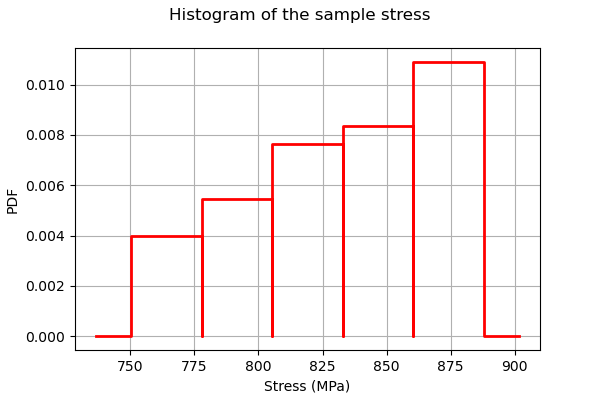

In [7]:
histoGraph = ot.HistogramFactory().build(outputStress / 1.0e6).drawPDF()
histoGraph.setTitle("Histogram of the sample stress")
histoGraph.setXTitle("Stress (MPa)")
histoGraph.setLegends([""])
histoGraph

Generate observation noise.

In [8]:
stressObservationNoiseSigma = 10.0e6  # (Pa)
noiseSigma = ot.Normal(0.0, stressObservationNoiseSigma)
sampleNoiseH = noiseSigma.getSample(sampleSize)
observedStress = outputStress + sampleNoiseH

In [9]:
observedStrain = inputSample[:, 0]

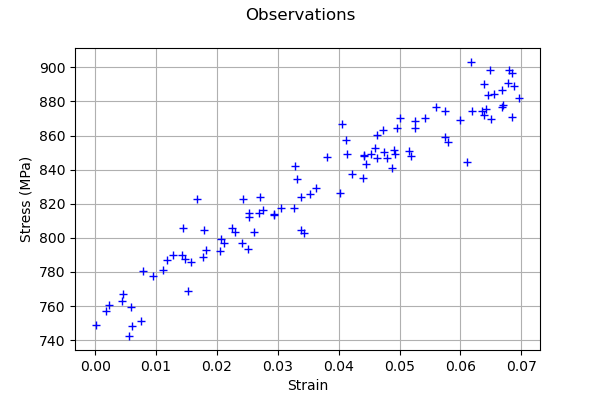

In [10]:
graph = ot.Graph("Observations", "Strain", "Stress (MPa)", True)
cloud = ot.Cloud(observedStrain, observedStress / 1.0e6)
graph.add(cloud)
graph

## Set the calibration parameters

Define the value of the reference values of the $\theta$ parameter. In the bayesian framework, this is called the mean of the *prior* gaussian distribution. In the data assimilation framework, this is called the *background*.

In [11]:
R = 700e6  # Exact : 750e6
C = 2500e6  # Exact : 2750e6
Gamma = 8.0  # Exact : 10
thetaPrior = ot.Point([R, C, Gamma])

The following statement creates the calibrated function from the model. The calibrated parameters R, C, Gamma are at indices 1, 2, 3 in the inputs arguments of the model.

In [12]:
calibratedIndices = [1, 2, 3]
mycf = ot.ParametricFunction(g, calibratedIndices, thetaPrior)

## Calibration with linear least squares

The `LinearLeastSquaresCalibration` class performs the linear least squares calibration by linearizing the model in the neighbourhood of the reference point.

In [13]:
algo = ot.LinearLeastSquaresCalibration(
    mycf, observedStrain, observedStress, thetaPrior, "SVD"
)

The `run` method computes the solution of the problem.

In [14]:
algo.run()

In [15]:
calibrationResult = algo.getResult()

## Analysis of the results

The `getParameterMAP` method returns the maximum of the posterior distribution of $\theta$.

In [16]:
thetaMAP = calibrationResult.getParameterMAP()
thetaMAP

class=Point name=Unnamed dimension=3 values=[7.47802e+08,2.79084e+09,10.3362]

We can compute a 95% confidence interval of the parameter $\theta^\star$. 

In [17]:
thetaPosterior = calibrationResult.getParameterPosterior()
thetaPosterior.computeBilateralConfidenceIntervalWithMarginalProbability(0.95)[0]

class=Interval name=Unnamed dimension=3 lower bound=class=Point name=Unnamed dimension=3 values=[7.39748e+08,2.24939e+09,-531.176] upper bound=class=Point name=Unnamed dimension=3 values=[7.55855e+08,3.3323e+09,551.848] finite lower bound=[1,1,1] finite upper bound=[1,1,1]

We can see that all three parameters are estimated with a large confidence interval.

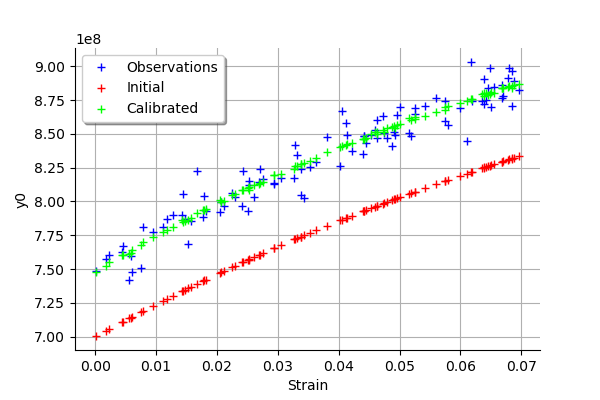

In [18]:
graph = calibrationResult.drawObservationsVsInputs()
graph.setLegendPosition("topleft")
graph

We see that there is a good fit after calibration, since the predictions after calibration (i.e. the green crosses) are close to the observations (i.e. the blue crosses).

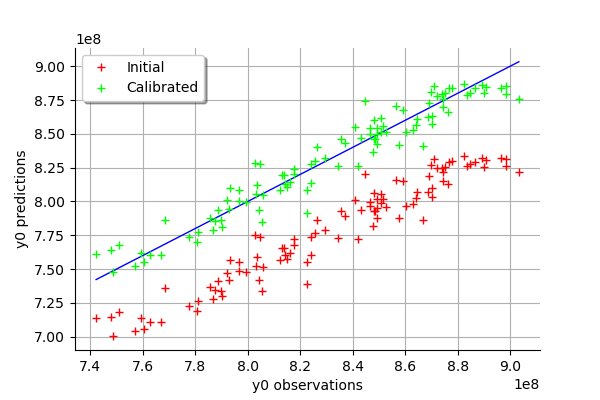

In [19]:
calibrationResult.drawObservationsVsPredictions()

We see that there is a much better fit after calibration, since the predictions are close to the diagonal of the graphics.

In [20]:
observationError = calibrationResult.getObservationsError()
observationError

class=Normal name=Normal dimension=1 mean=class=Point name=Unnamed dimension=1 values=[0] sigma=class=Point name=Unnamed dimension=1 values=[1.10416e+07] correlationMatrix=class=CorrelationMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[1]

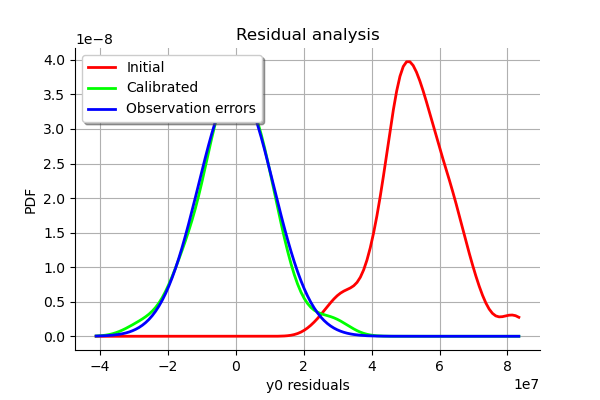

In [21]:
graph = calibrationResult.drawResiduals()
graph.setLegendPosition("topleft")
graph

The analysis of the residuals shows that the distribution is centered on zero and symmetric. This indicates that the calibration performed well. 

Moreover, the distribution of the residuals is close to being gaussian. 

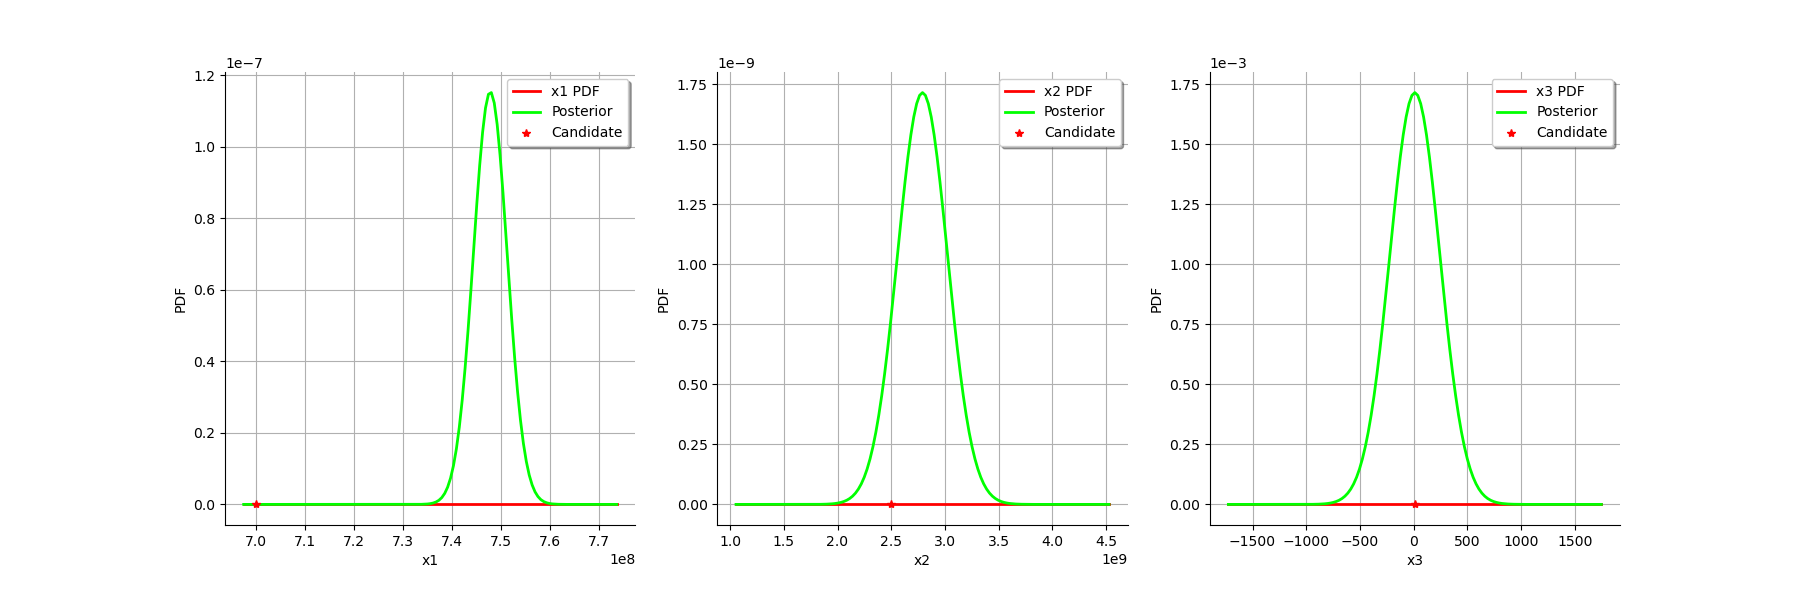

In [22]:
calibrationResult.drawParameterDistributions()

## Calibration with nonlinear least squares

The `NonLinearLeastSquaresCalibration` class performs the non linear least squares calibration by minimizing the squared euclidian norm between the predictions and the observations.

In [23]:
algo = ot.NonLinearLeastSquaresCalibration(
    mycf, observedStrain, observedStress, thetaPrior
)

The `run` method computes the solution of the problem.

In [24]:
algo.run()

In [25]:
calibrationResult = algo.getResult()

## Analysis of the results

The `getParameterMAP` method returns the maximum of the posterior distribution of $\theta$.

In [26]:
thetaMAP = calibrationResult.getParameterMAP()
thetaMAP

class=Point name=Unnamed dimension=3 values=[7.50102e+08,2.61003e+09,8.34741]

We can compute a 95% confidence interval of the parameter $\theta^\star$. 

In [27]:
thetaPosterior = calibrationResult.getParameterPosterior()
thetaPosterior.computeBilateralConfidenceIntervalWithMarginalProbability(0.95)[0]

class=Interval name=Unnamed dimension=3 lower bound=class=Point name=Unnamed dimension=3 values=[7.40699e+08,2.10865e+09,2.74615] upper bound=class=Point name=Unnamed dimension=3 values=[7.58284e+08,3.42292e+09,17.0101] finite lower bound=[1,1,1] finite upper bound=[1,1,1]

We can see that all three parameters are estimated with a large confidence interval.

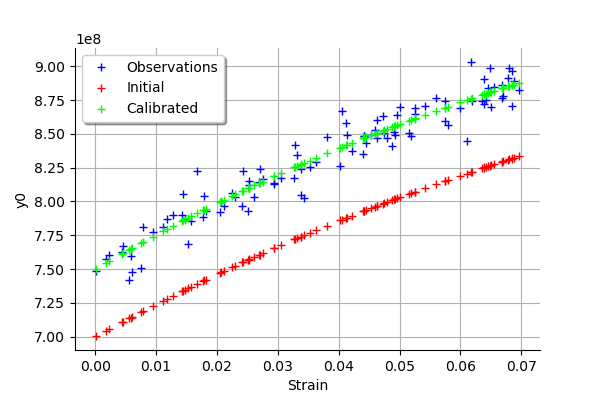

In [28]:
graph = calibrationResult.drawObservationsVsInputs()
graph.setLegendPosition("topleft")
graph

We see that there is a good fit after calibration, since the predictions after calibration (i.e. the green crosses) are close to the observations (i.e. the blue crosses).

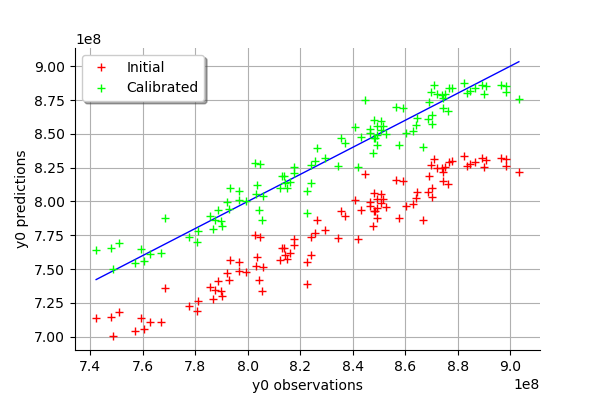

In [29]:
calibrationResult.drawObservationsVsPredictions()

We see that there is a much better fit after calibration, since the predictions are close to the diagonal of the graphics.

In [30]:
observationError = calibrationResult.getObservationsError()
observationError

class=Normal name=Normal dimension=1 mean=class=Point name=Unnamed dimension=1 values=[3570.99] sigma=class=Point name=Unnamed dimension=1 values=[1.09971e+07] correlationMatrix=class=CorrelationMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[1]

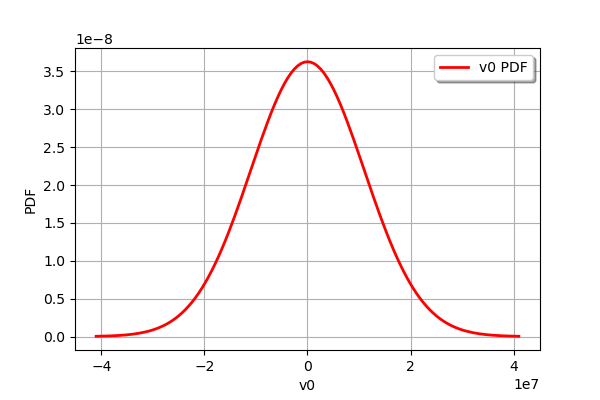

In [31]:
observationError.drawPDF()

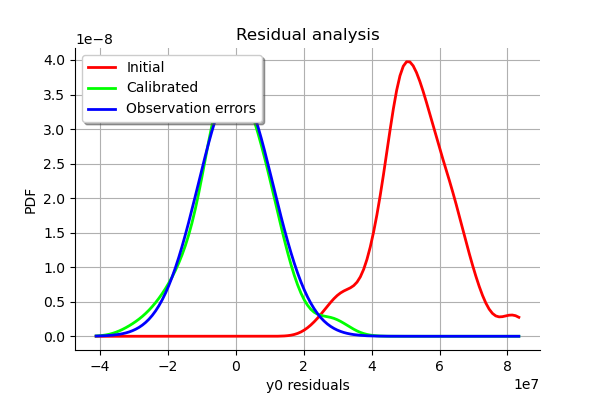

In [32]:
graph = calibrationResult.drawResiduals()
graph.setLegendPosition("topleft")
graph

The analysis of the residuals shows that the distribution is centered on zero and symmetric. This indicates that the calibration performed well. 

Moreover, the distribution of the residuals is close to being gaussian. This indicates that the observation error might be gaussian.

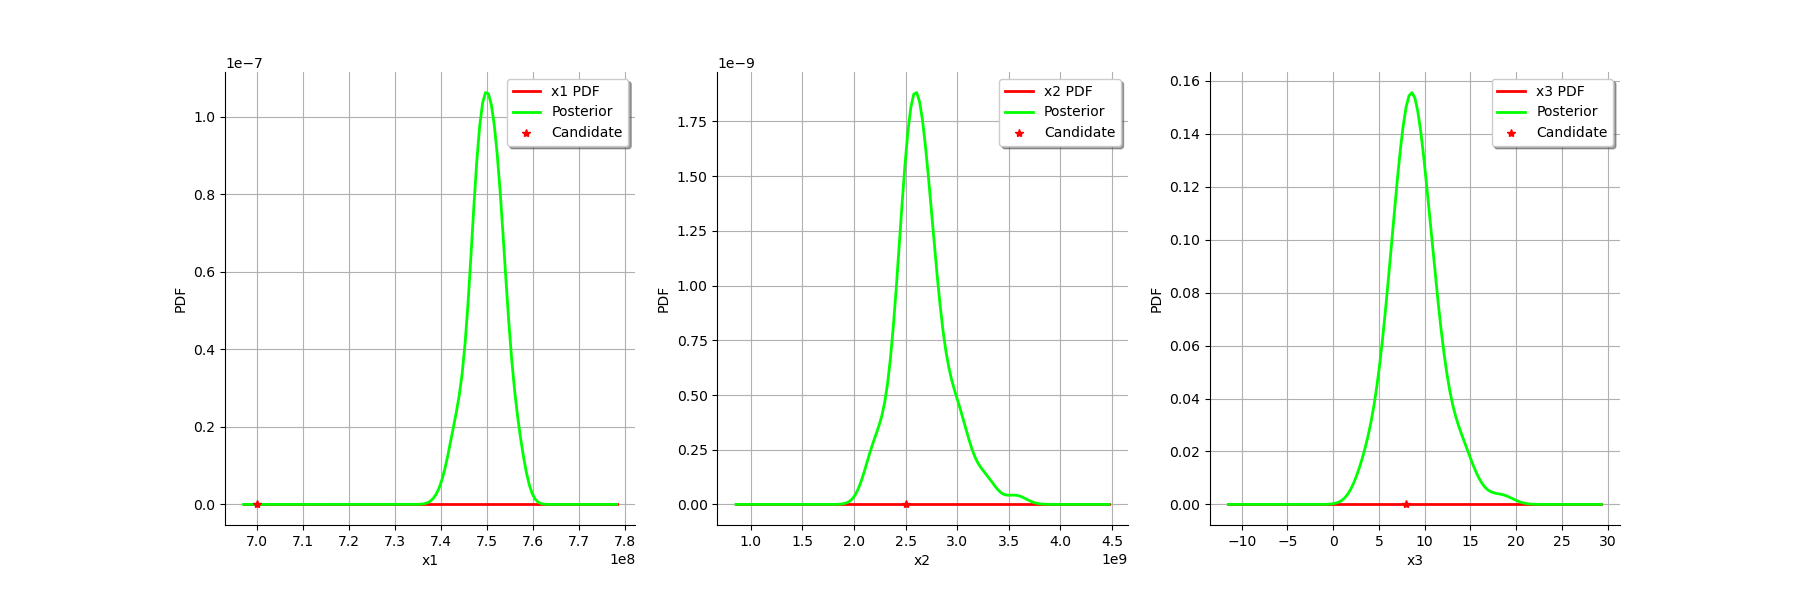

In [33]:
calibrationResult.drawParameterDistributions()

## Exercise 1: change the reference parameters

* Change the `thetaPrior` parameter and use the following numerical values:

In [34]:
R = 650e6  # Exact : 750e6
C = 2300e6  # Exact : 2750e6
Gamma = 6.0  # Exact : 10.0
thetaPrior = ot.Point([R, C, Gamma])

* How does the optimum value change with linear least squares? Can you explain these changes?
* How does the optimum value change with non linear least squares? Can you explain these changes?

## Exercise 2: reduce the dimension

Instead of calibrating the parameters R, C and Gamma, we now calibrate R and C, using the following value of the Gamma parameter:

In [35]:
Gamma = 8.0  # Exact : 10.0

To do this, please use the following function, which defines a model with parameters R and C.

In [36]:
def modelChabocheGammaFixe(X):
    strain, R, C = X
    gamma = 8.0
    stress = R + C * (1.0 - np.exp(-gamma * strain)) / gamma
    return [stress]


gGammaFixe = ot.PythonFunction(3, 1, modelChabocheGammaFixe)

R = 700e6  # Exact : 750e6
C = 2500e6  # Exact : 2750e6
thetaPriorGammaFixe = ot.Point([R, C])

calibratedIndices = [1, 2]
mycfGammaFixe = ot.ParametricFunction(
    gGammaFixe, calibratedIndices, thetaPriorGammaFixe
)

In the following questions, we consider linear least squares calibration.

* What are the values of the optimum parameters? 
* What are the changes with the previous situation where Gamma was calibrated too?
* What is the quality of the calibration?
* What does these changes imply in terms of the model?

## Exercise 3: calibration and Sobol' indices

We want to see the link between calibration and global sensitivity analysis. Indeed, it seems that the R, C and Gamma variables do not have the same effect on the output of the model. More precisely, the parameter Gamma is very large with linear least squares, which may require a deeper analysis.

To do this, we create a new model `myFunctionH` with R, C and Gamma as inputs. In this model, the `Strain` is assumed to be constant and equal to its maximum value. This particular choice amounts to consider the model on its most non linear input range.

In [37]:
strainReferenceValue = ot.Point([0.07])
strainReferenceValue

class=Point name=Unnamed dimension=1 values=[0.07]

In [38]:
strainIndex = [0]
myFunctionH = ot.ParametricFunction(g, strainIndex, strainReferenceValue)
myFunctionH

class=FunctionImplementation name=Unnamed description=[x1,x2,x3,y0] evaluationImplementation=class=ParametricEvaluation function=class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,y0] evaluationImplementation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[x0,x1,x2,x3,y0] parameter=class=Point name=Unnamed dimension=0 values=[] gradientImplementation=class=CenteredFiniteDifferenceGradient name=Unnamed epsilon=class=Point name=Unnamed dimension=4 values=[1e-05,1e-05,1e-05,1e-05] evaluation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[x0,x1,x2,x3,y0] parameter=class=Point name=Unnamed dimension=0 values=[] hessianImplementation=class=CenteredFiniteDifferenceHessian name=Unnamed epsilon=class=Point name=Unnamed dimension=4 values=[0.0001,0.0001,0.0001,0.0001] evaluation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[x0,x1,x2,x3,y0] parameter=class=Point name=Unnamed dimension=0 values=[] parameters positions=[0] parameters=class=PointWithDescription name=Unnamed dimension=1 description=[x0] values=[0.07] input positions=[1,2,3] gradientImplementation=class=ParametricGradient evaluation=class=ParametricEvaluation function=class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,y0] evaluationImplementation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[x0,x1,x2,x3,y0] parameter=class=Point name=Unnamed dimension=0 values=[] gradientImplementation=class=CenteredFiniteDifferenceGradient name=Unnamed epsilon=class=Point name=Unnamed dimension=4 values=[1e-05,1e-05,1e-05,1e-05] evaluation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[x0,x1,x2,x3,y0] parameter=class=Point name=Unnamed dimension=0 values=[] hessianImplementation=class=CenteredFiniteDifferenceHessian name=Unnamed epsilon=class=Point name=Unnamed dimension=4 values=[0.0001,0.0001,0.0001,0.0001] evaluation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[x0,x1,x2,x3,y0] parameter=class=Point name=Unnamed dimension=0 values=[] parameters positions=[0] parameters=class=PointWithDescription name=Unnamed dimension=1 description=[x0] values=[0.07] input positions=[1,2,3] hessianImplementation=class=ParametricHessian evaluation=class=ParametricEvaluation function=class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,y0] evaluationImplementation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[x0,x1,x2,x3,y0] parameter=class=Point name=Unnamed dimension=0 values=[] gradientImplementation=class=CenteredFiniteDifferenceGradient name=Unnamed epsilon=class=Point name=Unnamed dimension=4 values=[1e-05,1e-05,1e-05,1e-05] evaluation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[x0,x1,x2,x3,y0] parameter=class=Point name=Unnamed dimension=0 values=[] hessianImplementation=class=CenteredFiniteDifferenceHessian name=Unnamed epsilon=class=Point name=Unnamed dimension=4 values=[0.0001,0.0001,0.0001,0.0001] evaluation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[x0,x1,x2,x3,y0] parameter=class=Point name=Unnamed dimension=0 values=[] parameters positions=[0] parameters=class=PointWithDescription name=Unnamed dimension=1 description=[x0] values=[0.07] input positions=[1,2,3]

The distribution of the R, C and Gamma parameters is unknown. Without further information, we use Gaussian distribution with a coefficient of variation equal to 20%.

In [39]:
def NormalFromMuCV(mu, cv):
    """Create a Normal from its mean and its coeff. of var."""
    sigma = mu * cv
    distribution = ot.Normal(mu, sigma)
    return distribution

In [40]:
cv = 0.2
R = NormalFromMuCV(650.0e6, cv)
R.setDescription(["R"])
C = NormalFromMuCV(2300.0e6, cv)
C.setDescription(["C"])
Gamma = NormalFromMuCV(6.0, cv)
Gamma.setDescription(["Gamma"])
inputDistribution = ot.ComposedDistribution([R, C, Gamma])

We now want to estimate the sensitivity of the function `myFunctionH` with respect to the R, C and Gamma input variables. 

* Estimate the Sobol' sensitivity indices of the `myFunctionH` with respect to R, C and Gamma. To do this, use the `SobolSimulationAlgorithm` with the `SaltelliSensitivityAlgorithm` estimator.
* What are the most influential variables? What are the less influential variables?
* How does this is related to the results of the calibration?

## Exercise 4: linearity of the model

We see that the results of the linear calibration are very close to the results of the nonlinear calibration in terms of optimum values, but with very different distributions of the optimum values. This is why we want to see if `myFunctionH` is a linear model with respect to R, C and Gamma.  

* Create a sample with 1000 points from the `inputDistribution`. 
* Evaluate the corresponding output sample using `myFunctionH`. 
* Use the `LinearLeastSquares` class and create a linear model.
* Compute the R2 coefficient: is the model approximately linear?
* Compute the Standardized Regression Coefficients (SRC) of the function `myFunctionH` with respect to Epsilon, R, C and Gamma. How close are they to the Sobol' indices?